# Exploring "Weighted SHAP" values

(or "Weighted TS/PSI" values, if you prefer)

## Setup

In [2]:
import pandas as pd
import numpy as np
import sys
sys.path.append('/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/site-packages')
try:
    import shap
except:
    !pip install shap
import probatus.datasets
import probatus.models
import probatus.stat_tests
from sklearn.preprocessing import normalize
import matplotlib.pyplot as plt
shap.initjs()

## Import Lending Club dataset

Publicly-available credit risk / default dataset

In [3]:
credit_df, X_train, y_train, X_test, y_test = probatus.datasets.lending_club()
X = credit_df.drop(['id', 'loan_issue_date','default'], axis=1)

In [4]:
n_features = X.shape[1]
print(f"There are {n_features} features.")

There are 15 features.


## Import pre-trained Random Forest model

In [5]:
model = probatus.models.lending_club_model()

/Users/fb24xi/miniconda3/envs/probapy/lib/python3.6/site-packages/sklearn/base.py:306: UserWarning: Trying to unpickle estimator DecisionTreeClassifier from version 0.20.2 when using version 0.21.3. This might lead to breaking code or invalid results. Use at your own risk.
  UserWarning)
/Users/fb24xi/miniconda3/envs/probapy/lib/python3.6/site-packages/sklearn/base.py:306: UserWarning: Trying to unpickle estimator RandomForestClassifier from version 0.20.2 when using version 0.21.3. This might lead to breaking code or invalid results. Use at your own risk.
  UserWarning)


## SHAP values for each feature in the model

In [6]:
explainer = shap.TreeExplainer(model)
shap_values = explainer.shap_values(X)

### Plot visual summary

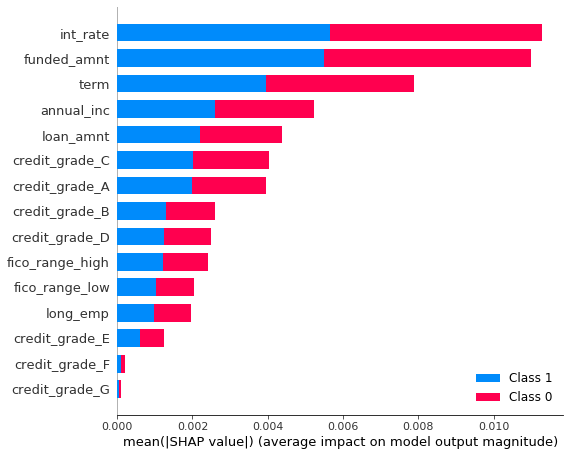

In [7]:
shap.summary_plot(shap_values, X, feature_names=X.columns)

### Calculate SHAP values & get associated features

In [8]:
mean_abs_shap = np.mean(abs(shap_values[0]), axis=0)
print(mean_abs_shap)

[2.19281846e-03 5.48831937e-03 3.94565183e-03 5.64369143e-03
 2.61036714e-03 1.02505904e-03 1.20914016e-03 9.85094054e-04
 1.97845646e-03 1.30404857e-03 2.01246062e-03 1.25015174e-03
 6.20301549e-04 1.10653809e-04 4.79947725e-05]


In [9]:
features = X.columns
print(features)

Index(['loan_amnt', 'funded_amnt', 'term', 'int_rate', 'annual_inc',
       'fico_range_low', 'fico_range_high', 'long_emp', 'credit_grade_A',
       'credit_grade_B', 'credit_grade_C', 'credit_grade_D', 'credit_grade_E',
       'credit_grade_F', 'credit_grade_G'],
      dtype='object')


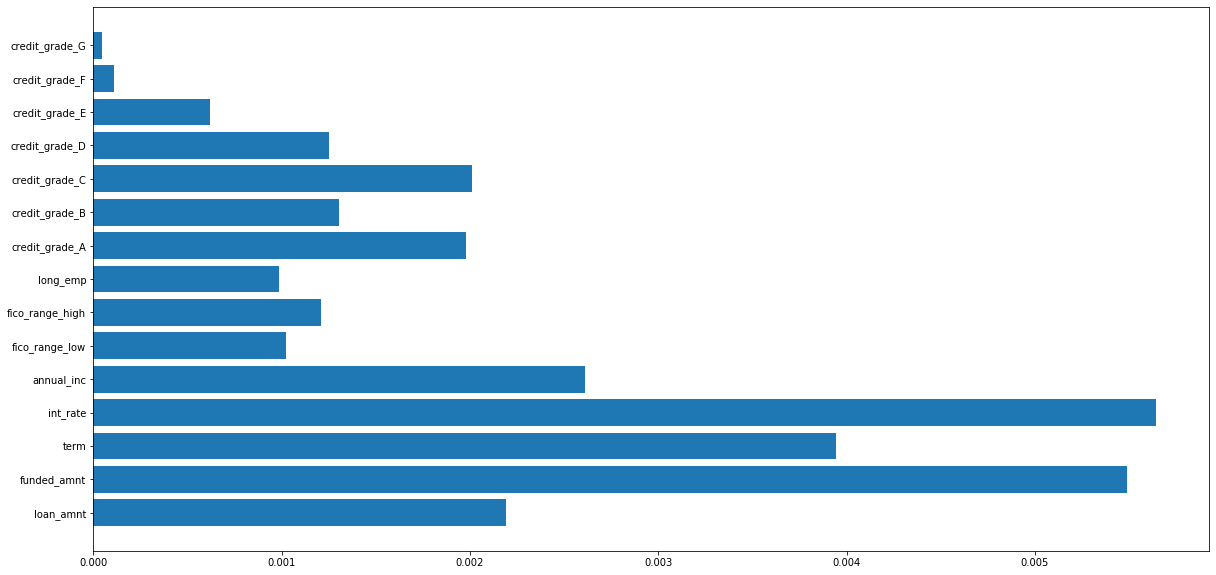

In [10]:
plt.figure(figsize=(20,10))
plt.barh(features, mean_abs_shap);

### Normalize SHAP values

Tried this, but I think it makes more sense to do normalize(TS * SHAP) not (TS * normalize(SHAP)) or (normalize(TS) * normalize(SHAP))

In [11]:
norm_mean_abs_shap = normalize(mean_abs_shap.reshape(1,-1), 'max')[0]

#### Visualize the normalized SHAP values

_N.B._ Not sorted as in SHAP `summary_plot` above

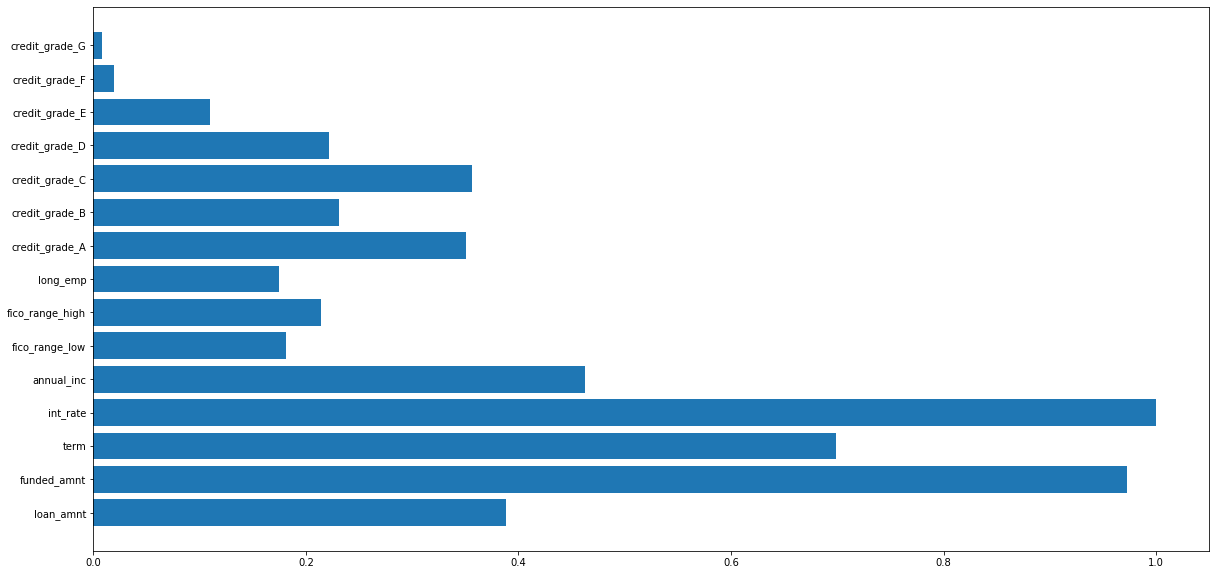

In [12]:
plt.figure(figsize=(20,10))
plt.barh(features, norm_mean_abs_shap);

## Visualize original feature distributions

In [13]:
X.head()

,loan_amnt,funded_amnt,term,int_rate,annual_inc,fico_range_low,fico_range_high,long_emp,credit_grade_A,credit_grade_B,credit_grade_C,credit_grade_D,credit_grade_E,credit_grade_F,credit_grade_G
826036,30000.0,30000.0,36,19.92,132000.0,715.0,719.0,0,0,0,0,1,0,0,0
1338080,28375.0,28375.0,36,17.57,78000.0,680.0,684.0,0,0,0,0,1,0,0,0
2058335,28800.0,28800.0,60,9.93,205000.0,735.0,739.0,1,0,1,0,0,0,0,0
1167545,16000.0,16000.0,60,15.61,60000.0,705.0,709.0,1,0,0,0,1,0,0,0
1322336,6000.0,6000.0,36,12.99,78000.0,660.0,664.0,0,0,1,0,0,0,0,0


/Users/fb24xi/miniconda3/envs/probapy/lib/python3.6/site-packages/ipykernel_launcher.py:4: FutureWarning: The 'get_values' method is deprecated and will be removed in a future version. Use '.to_numpy()' or '.array' instead.
  after removing the cwd from sys.path.


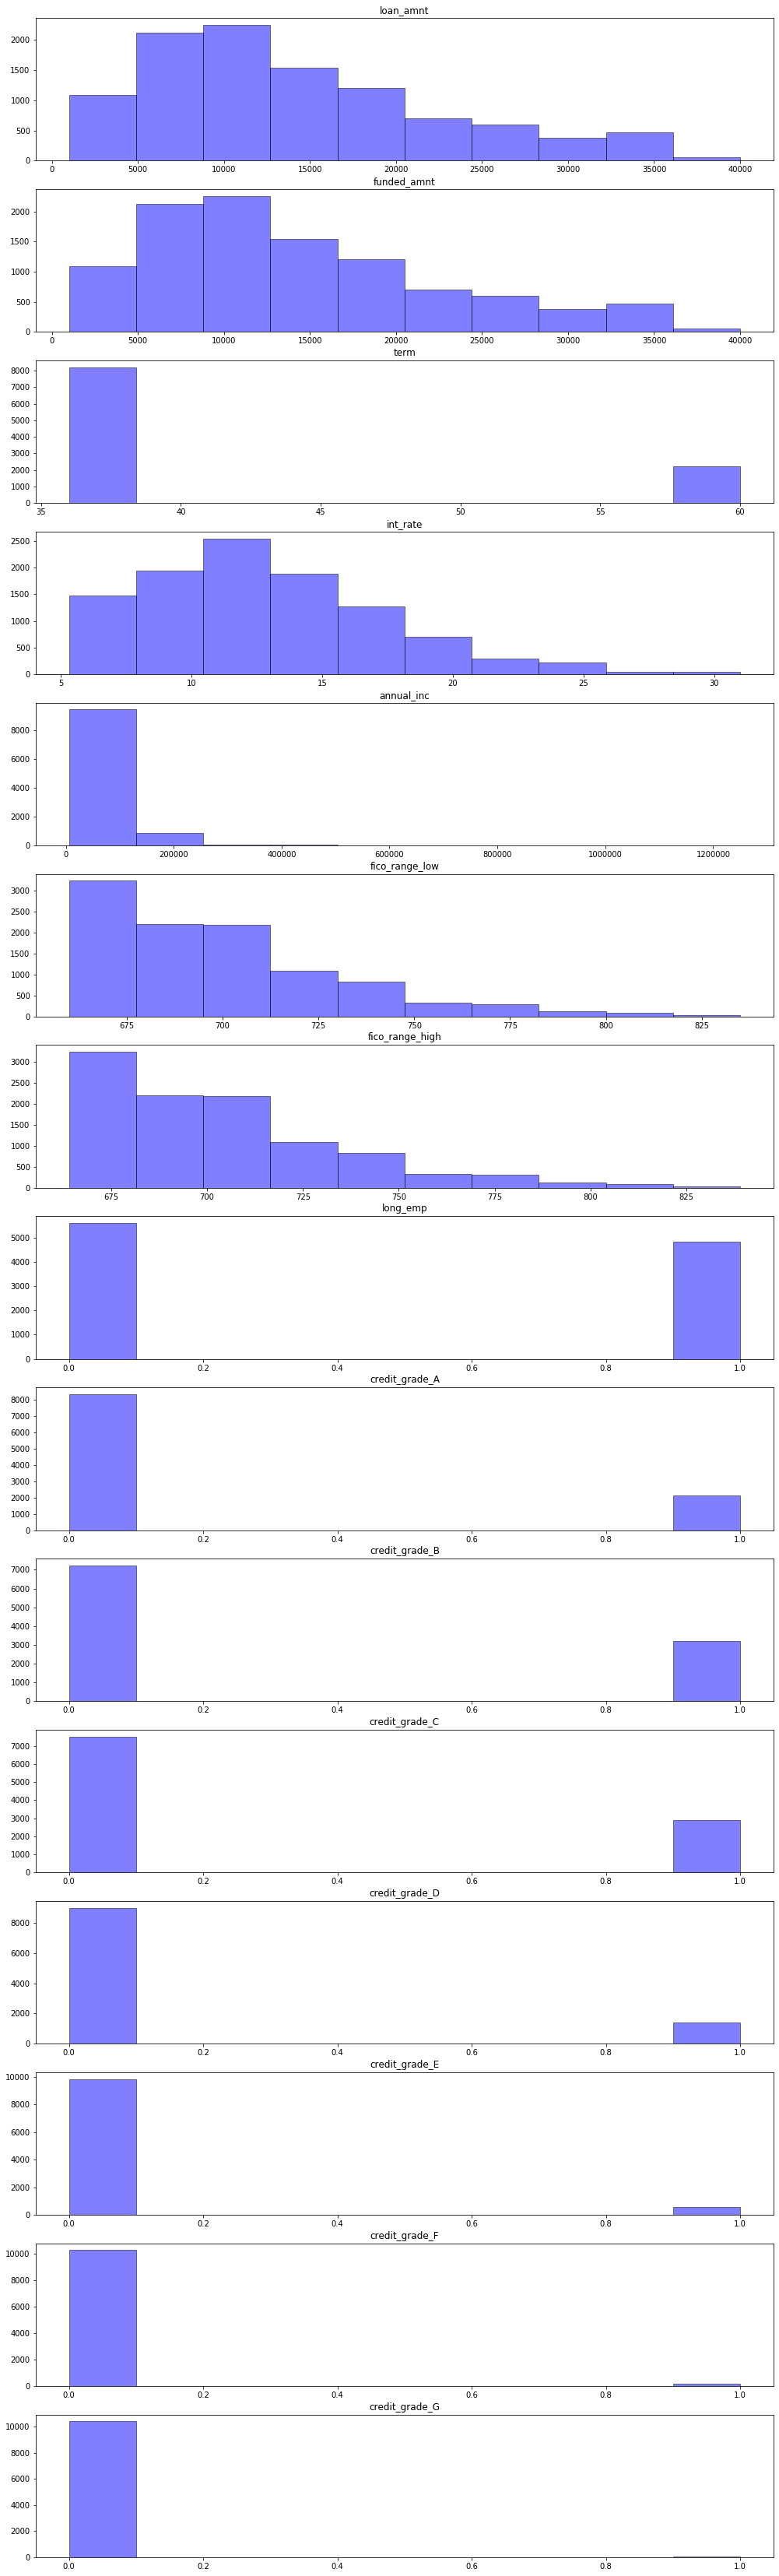

In [14]:
fig, axs = plt.subplots(n_features, figsize=(17,60))

for feature_index in range(0,n_features):
    axs[feature_index].hist(X.iloc[:,feature_index].get_values(), color='b', alpha=0.5, edgecolor='k');
    axs[feature_index].title.set_text(X.columns[feature_index])

plt.show()

### Shift original feature distributions and visualize difference

Need to treat encoded (0, 1) features separately.

For now focusing on non-one-hot-encoded features.

In [15]:
X_shift = X.copy()
shift_pct = .02

for feature_index in range(0, n_features):
    if len(X.iloc[:,feature_index].unique()) == 2: # could be more robust test
        print(f"Skipping one-hot encoded feature: {X.columns[feature_index]}")
    else:
        X_shift.iloc[:,feature_index] = (1.0 + shift_pct) * X.iloc[:,feature_index]

Skipping one-hot encoded feature: term
Skipping one-hot encoded feature: long_emp
Skipping one-hot encoded feature: credit_grade_A
Skipping one-hot encoded feature: credit_grade_B
Skipping one-hot encoded feature: credit_grade_C
Skipping one-hot encoded feature: credit_grade_D
Skipping one-hot encoded feature: credit_grade_E
Skipping one-hot encoded feature: credit_grade_F
Skipping one-hot encoded feature: credit_grade_G


/Users/fb24xi/miniconda3/envs/probapy/lib/python3.6/site-packages/ipykernel_launcher.py:4: FutureWarning: The 'get_values' method is deprecated and will be removed in a future version. Use '.to_numpy()' or '.array' instead.
  after removing the cwd from sys.path.
/Users/fb24xi/miniconda3/envs/probapy/lib/python3.6/site-packages/ipykernel_launcher.py:6: FutureWarning: The 'get_values' method is deprecated and will be removed in a future version. Use '.to_numpy()' or '.array' instead.
  


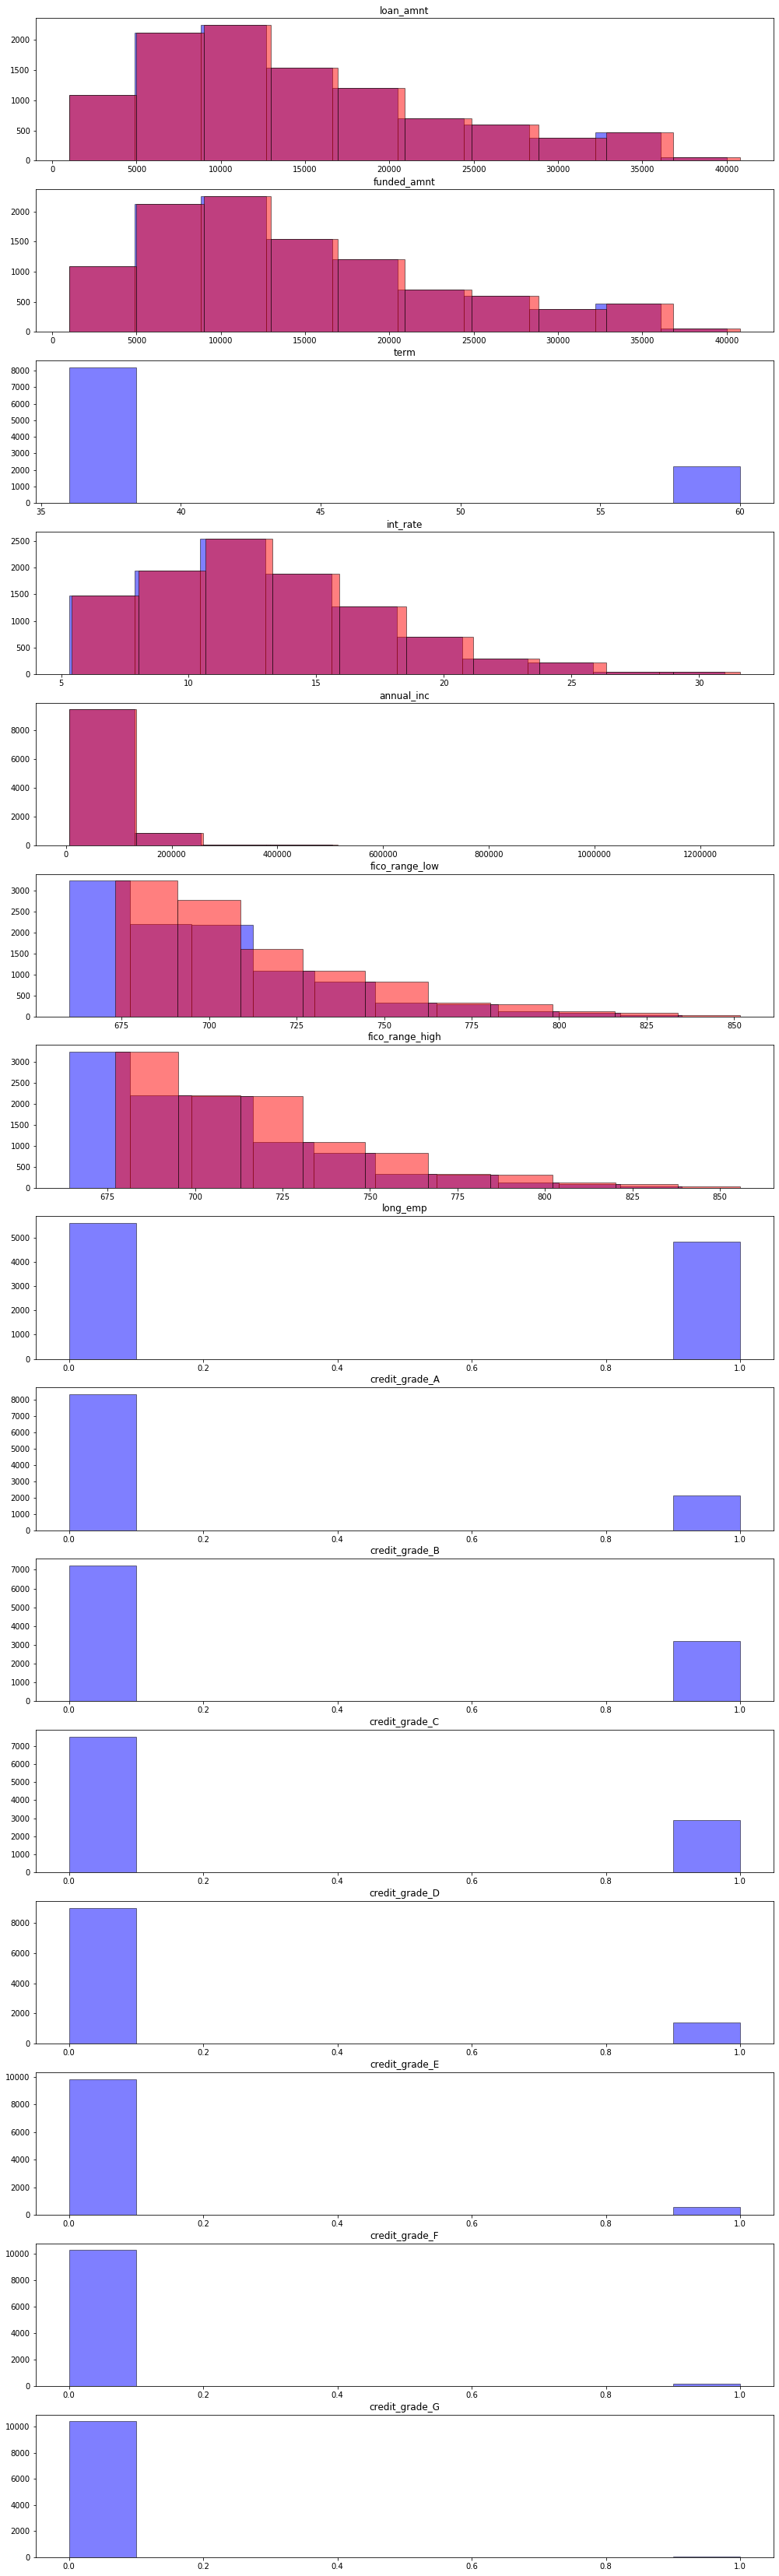

In [16]:
fig, axs = plt.subplots(n_features, figsize=(17,60))

for feature_index in range(0,n_features):
    axs[feature_index].hist(X.iloc[:,feature_index].get_values(), color='b', alpha=0.5, edgecolor='k');
    if len(X.iloc[:,feature_index].unique()) != 2: # could be more robust test
        axs[feature_index].hist(X_shift.iloc[:,feature_index].get_values(), color='r', alpha=0.5, edgecolor='k');
    axs[feature_index].title.set_text(X.columns[feature_index])

plt.show()

## Calculate TS of features' dist shifts

Also creates new df w/ feature name, shift TS, and norm SHAP value

In [17]:
df = pd.DataFrame(columns=['feature', 'shift_TS', 'SHAP'])
for feature_index in range(0,n_features):
    if len(X.iloc[:,feature_index].unique()) == 2: # could be more robust test
        print(f"Skipping one-hot encoded feature: {X.columns[feature_index]}")
        psi = 0
    else:
        print(f"Testing feature: {X.columns[feature_index]}")
        psi = probatus.stat_tests.psi(X.iloc[:,feature_index].get_values(), X_shift.iloc[:,feature_index].get_values(),\
                                    verbose=False, m=len(X.iloc[:,feature_index].get_values()),
                                    n=len(X_shift.iloc[:,feature_index].get_values()))
    df = df.append({'feature': X.columns[feature_index], 'shift_TS': psi, 
                    'SHAP': mean_abs_shap[feature_index]}, ignore_index=True)

Testing feature: loan_amnt


/Users/fb24xi/miniconda3/envs/probapy/lib/python3.6/site-packages/ipykernel_launcher.py:8: FutureWarning: The 'get_values' method is deprecated and will be removed in a future version. Use '.to_numpy()' or '.array' instead.
  
/Users/fb24xi/miniconda3/envs/probapy/lib/python3.6/site-packages/ipykernel_launcher.py:9: FutureWarning: The 'get_values' method is deprecated and will be removed in a future version. Use '.to_numpy()' or '.array' instead.
  if __name__ == '__main__':
/Users/fb24xi/miniconda3/envs/probapy/lib/python3.6/site-packages/ipykernel_launcher.py:10: FutureWarning: The 'get_values' method is deprecated and will be removed in a future version. Use '.to_numpy()' or '.array' instead.
  # Remove the CWD from sys.path while we load stuff.


TypeError: psi() got an unexpected keyword argument 'm'

In [ ]:
df.sort_values(by='shift_TS', ascending=True, inplace=True)
df

In [ ]:
plt.figure(figsize=(20,10))
plt.barh(df['feature'], df['shift_TS'], color='m');
plt.title('shift_TS');
plt.show()

## Define new metric for "shift importance"

In [ ]:
shift_importance = np.array(df['shift_TS'] * df['SHAP'])

In [ ]:
norm_shift_importance = normalize(shift_importance.reshape(1,-1), 'max')[0]

In [ ]:
df.insert(loc=3, column='norm_shift_importance', value=norm_shift_importance)

In [ ]:
df.sort_values(by='norm_shift_importance', inplace=True)

In [ ]:
df

In [ ]:
plt.figure(figsize=(20,10))
plt.barh(df['feature'], df['norm_shift_importance'], color='g');
plt.title('norm_shift_importance');
plt.show()

Thoughts:

* So if I had looked only at PSI, I would have investigated these features first: 
 * `annual_inc`
 * `loan_amnt`
 * `funded_amnt`
* If I had looked only at SHAP, I would have investigated these features first:
 * `int_rate`
 * `funded_amnt`
 * `annual_inc`
* Now if I look at (PSI * SHAP), I would instead investigate these features first:
 * `annual_inc`
 * `funded_amnt`
 * `loan_amnt`
* feature `int_rate` has highest SHAP value, but a 2% change previously resulted in very low (insignificance) PSI value and also very low (PSI * SHAP).
* other normalization / weighting strategies?
* add other information?

## TODO

* Repeat for KS. Because PSI is so ill-behaved, I feel that the PSI value of 34 (!) for feature `annual_inc` has skewed the results.
* Try shifting features with a different percentage for each feature to get a better feel for this. *Especially the case of where a high SHAP feature is shifted very little while a low SHAP value is shifted considerably.*

In [ ]:
X_shift.loc[:, 'fico_range_high'] = (1.0 + 0.25) * X.loc[:, 'fico_range_high']

And repeat procedure:

In [ ]:
df = pd.DataFrame(columns=['feature', 'shift_TS', 'SHAP'])
for feature_index in range(0,n_features):
    if len(X.iloc[:,feature_index].unique()) == 2: # could be more robust test
        print(f"Skipping one-hot encoded feature: {X.columns[feature_index]}")
        psi = 0
    else:
        print(f"Testing feature: {X.columns[feature_index]}")
        psi = probatus.stat_tests.psi(X.iloc[:,feature_index].get_values(), X_shift.iloc[:,feature_index].get_values(),\
                                    verbose=False, m=len(X.iloc[:,feature_index].get_values()),
                                    n=len(X_shift.iloc[:,feature_index].get_values()))
    df = df.append({'feature': X.columns[feature_index], 'shift_TS': psi, 
                    'SHAP': mean_abs_shap[feature_index]}, ignore_index=True)
df.sort_values(by='shift_TS', ascending=True, inplace=True)
shift_importance = np.array(df['shift_TS'] * df['SHAP'])
norm_shift_importance = normalize(shift_importance.reshape(1,-1), 'max')[0]
df.insert(loc=3, column='norm_shift_importance', value=norm_shift_importance)
df.sort_values(by='norm_shift_importance', inplace=True)
plt.figure(figsize=(20,10))
plt.barh(df['feature'], df['norm_shift_importance'], color='k');
plt.title('norm_shift_importance');
plt.show()